# **Instruction for POS Tagging Using RNN (LSTM) with Arabic Dataset**
​
**Dataset:**
The dataset provided is named "Arabic POS.conllu". It contains labeled data for Arabic text with Part-of-Speech (POS) tags in CoNLL-U format.
​

**Objective:**
perform Part-of-Speech (POS) tagging on Arabic text using Recurrent Neural Networks (RNNs). Specifically, you will use the Universal POS (UPOS) tags for tagging. UPOS is a standardized set of POS tags that aims to cover all languages.
​
​
Accuracy
​
**Instructions:**
1. **Data Preprocessing:**
   - Load the provided dataset "Arabic POS.conllu" useing pyconll library
   - Preprocess the data as necessary, including tokenization
​
2. **Model Building:**
   - Design an RNN-based model architecture suitable for POS tagging >>(LSTM) with embedding layer
   - Define the input and output layers of the model. The input layer should accept sequences of tokens, and the output layer should produce the predicted UPOS tags for each token.
​
3. **Training:** I will use 80% of the data for training and 20% for evaluation.
​
4. **Evaluation:** Evaluation metric:Accuracy
​

#  More About data

Arabic text annotated with POS tags in CoNLL-U format. Each line represents a token along with its POS tag and other linguistic annotations. Let's break down the format of each line:

*     ID: Each token is assigned a unique identifier, starting from 1 and increasing sequentially.
*     Word form: The actual word in the text.
*     Lemma: The base form or dictionary form of the word.
*     Universal POS tag: The POS tag according to the universal POS tagset.
*     Extended POS tag: This tag provides additional information about the word, such as gender, number, case, etc.
*     Other annotations: These can include features like morphological features, dependency relations, and more.

**For example, let's take the first line:**<br>
1    برلين    بَرلِين    X    X---------    Foreign=Yes    2    nsubj    2:nsubj    Vform=بَرلِين|Gloss=Berlin|Root=barlIn|Translit=barlīn|LTranslit=barlīn

*     ID: 1
*     Word form: برلين
*     Lemma: بَرلِين
*     Universal POS tag: X (This indicates that the word is a foreign word)
*     Extended POS tag: X--------- (No specific POS information available)
*     Other annotations: Foreign=Yes, indicating that the word is a foreign word. Gloss provides the gloss or translation of the word, Root indicates the root form, and Translit provides the transliteration of the word.


# Import used libraries

In [3]:
!pip install pyarabic
! pip install pyconll

In [4]:
import pyconll
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
# import spacy
# from spacy import displacy
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("ggplot")
import pyarabic.araby as araby
from keras.preprocessing.sequence import pad_sequences
from IPython.display import HTML
import random

2024-05-07 02:26:44.209875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 02:26:44.209923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 02:26:44.211414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Dataset

In [5]:
file_path="/kaggle/input/arabic-pos/Arabic POS.conllu"
dataset = pyconll.load_from_file(file_path)

# Quickly view on the dataset 

In [6]:
# Initialize lists to store data
samples = []

# Iterate over a few sentences to collect samples
num_samples = 5
for i, sentence in enumerate(dataset):
    if i >= num_samples:
        break
    # Initialize lists to store tokens and POS tags for the current sentence
    tokens = []
    pos_tags = []
    # Iterate over tokens in the sentence and collect data
    for token in sentence:
        tokens.append(token.form)
        pos_tags.append(token.upos)
    # Append data for the current sentence as a tuple (word form, POS tag)
    samples.append((tokens, pos_tags))

# Create a DataFrame from the collected samples
df = pd.DataFrame(samples, columns=['Word Form', 'POS'])

# Print the DataFrame
print(df)

                                           Word Form  \
0  [برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...   
1  [برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...   
2  [وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...   
3  [وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...   
4  [واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...   

                                                 POS  
0  [X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NO...  
1  [X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, PUNCT...  
2  [None, CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUN...  
3  [None, CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB...  
4  [None, CCONJ, VERB, NOUN, NOUN, ADP, SCONJ, NO...  


# Preprocessing

In [7]:
def preprocess_data(dataset):
    # Tokenization
    tokenized_sentences = []
    pos_tags = []
    for sentence in dataset:
        tokens = [token.form for token in sentence]
        pos = [token.upos for token in sentence]
        tokenized_sentences.append(tokens)
        pos_tags.append(pos)
    return tokenized_sentences, pos_tags


In [8]:
# Preprocess data
tokenized_sentences, pos_tags = preprocess_data(dataset)

# Convert tokens and POS tags to numeric representation
vocab = set([word for sentence in tokenized_sentences for word in sentence])
pos_tag_set = set([tag for tags in pos_tags for tag in tags])

word2idx = {w: i + 1 for i, w in enumerate(vocab)}
pos2idx = {t: i for i, t in enumerate(pos_tag_set)}
idx2pos = {i: t for i, t in enumerate(pos_tag_set)}

X = [[word2idx[token] for token in sentence] for sentence in tokenized_sentences]
y = [[pos2idx[tag] for tag in tags] for tags in pos_tags]

In [9]:
X[0]

[18291,
 923,
 23080,
 15153,
 9084,
 12002,
 24345,
 17080,
 28043,
 13801,
 1836,
 13801,
 19240]

In [10]:
y[0]

[6, 5, 14, 14, 13, 7, 14, 14, 14, 12, 6, 12, 13]

### Determine the length of the longest sentence

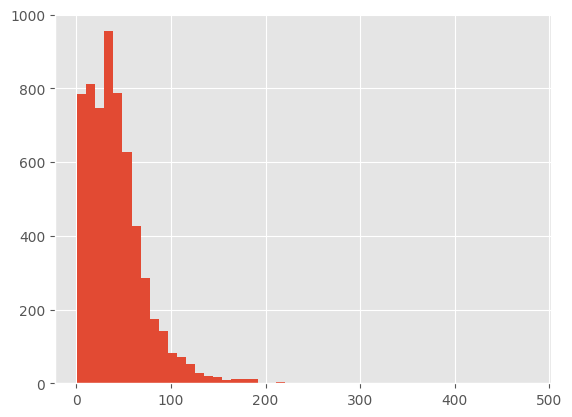

In [11]:
plt.hist([len(s) for s in X], bins=50)
plt.show()

In [12]:
max_len = max(len(seq) for seq in X)
print("Maximum sequence length:", max_len)

Maximum sequence length: 478


**In this case, I will use max length =150**

### Pad sequences

In [13]:
# Pad sequences to have same length
max_len=150
X_padded =pad_sequences(X, maxlen=max_len, padding='post')
y_padded =pad_sequences(y, maxlen=max_len, padding='post')

# Modelling

In [14]:
# Model Building
def build_rnn_model(input_dim, output_dim, input_length):
    model = Sequential([
        Embedding(input_dim=input_dim, output_dim=64, input_length=input_length),
        LSTM(128, return_sequences=True),
        TimeDistributed(Dense(output_dim, activation='softmax'))
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

# Training
def train_model(model, X_train, y_train, epochs=5, batch_size=32):
    history=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    return history

# Evaluation
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

In [15]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

# Build RNN model
model = build_rnn_model(input_dim=len(vocab) + 1, output_dim=len(pos_tag_set), input_length=max_len)

# Train model
history=train_model(model, X_train, y_train)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.7440 - loss: 1.0075 - val_accuracy: 0.8614 - val_loss: 0.4705
Epoch 2/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8847 - loss: 0.3897 - val_accuracy: 0.9444 - val_loss: 0.2163
Epoch 3/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9607 - loss: 0.1632 - val_accuracy: 0.9720 - val_loss: 0.1132
Epoch 4/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9862 - loss: 0.0746 - val_accuracy: 0.9777 - val_loss: 0.0837
Epoch 5/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9924 - loss: 0.0420 - val_accuracy: 0.9791 - val_loss: 0.0738


## Evaluation

In [16]:
# Evaluate model
evaluate_model(model, X_test, y_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9794 - loss: 0.0724
Test Loss: 0.07581442594528198
Test Accuracy: 0.9779150485992432


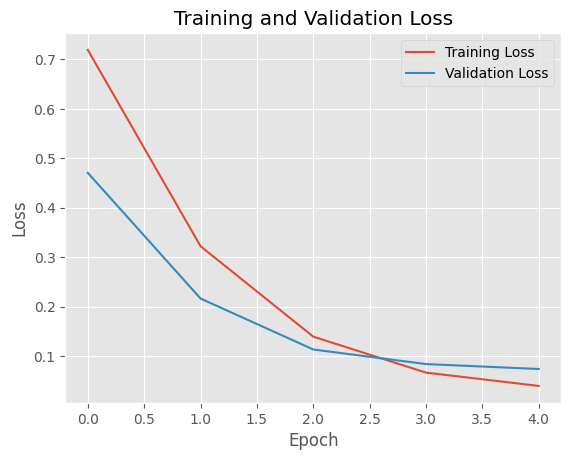

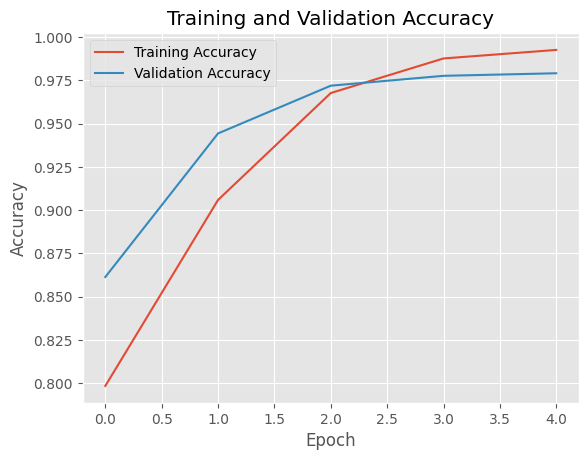

In [17]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save Model to use it Later..

In [18]:
model.save("Arabic POS.h5")


-- --

# Use Model

In [19]:
# Load the model
model = tf.keras.models.load_model("Arabic POS.h5")

In [20]:
def predict(text):
    max_len = 150
    
    # Tokenize the input text
    tokens = text.split()
    
    # Convert tokens to numerical IDs using word2idx mapping
    text_ids = [word2idx.get(token, 0) for token in tokens]
    
    # Pad sequences to ensure uniform length
    padded_sequence = pad_sequences([text_ids], maxlen=max_len, padding="post")
    
    
    # Make predictions
    predictions = model.predict([padded_sequence[0].reshape(1, -1)])
    
   
    # Process predictions and print results
    print("{:15}\t {}\n".format("Word", "Pred POS"))
    print("-" * 30)
    for i in range(len(tokens)):
        print("{:15}\t{}".format(tokens[i], idx2pos[np.argmax(predictions[0][i])]))
        
    
    
    # Create a list to store (token, predicted POS) tuples
    token_pos_predictions = []
    
    # Process predictions and append results to the list
    for i in range(len(tokens)):
        token = tokens[i]
        predicted_pos = idx2pos[np.argmax(predictions[0][i])]
        token_pos_predictions.append((token, predicted_pos))
    
    return token_pos_predictions

   

In [80]:
new_text = "تعيش ندى في مصر"
doc=predict(new_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Word           	 Pred POS

------------------------------
تعيش           	VERB
ندى            	PART
في             	ADP
مصر            	NOUN


In [77]:
doc

[('تعيش', 'VERB'), ('ندى', 'PART'), ('في', 'ADP'), ('مصر', 'NOUN')]

# Visualize Tokens with POS

In [79]:
def visualize_tokens_with_pos(doc):
    html = "<div style='font-family: Arial;'>"
    for token, pos in reversed(doc):  # Reversed order
        bg_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        html += f"<span style='background-color: {bg_color}; padding: 2px; margin-right: 2px;'>{token} ({pos})</span>"
    html += "</div>"
    display(HTML(html))


visualize_tokens_with_pos(doc)
